# Mixture of Experts (MoE) Implementation for "Thinking Fast and Slow"

This notebook implements a Mixture of Experts (MoE) architecture to replicate key cognitive theories from Daniel Kahneman's "Thinking Fast and Slow". Unlike the previous CAV approach that manipulated existing model representations, this implementation creates specialized expert modules for different thinking styles and cognitive biases.

## Overview

The Mixture of Experts architecture consists of:
1. Multiple expert networks (System 1, System 2, and various cognitive biases)
2. A router network that decides which expert(s) to use for a given input
3. A combiner that integrates outputs from multiple experts

This approach is particularly innovative for modeling Kahneman's theories because:
- It explicitly models the dual-process theory with separate neural pathways
- It allows for dynamic switching between thinking styles based on context
- It can model competition between System 1 and System 2 processes
- It provides interpretable insights into when different thinking styles are activated

Let's implement this architecture for replicating "Thinking Fast and Slow" theories.

## 1. Setup and Dependencies

In [3]:
# Apple Silicon compatibility settings
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_NO_MPS"] = "1"  # Completely disable MPS

# Install required packages if needed
!pip install torch transformers datasets numpy matplotlib scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers import GPT2LMHeadModel, GPT2Config
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
import random
from typing import List, Dict, Tuple, Optional, Union, Any

# Use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print(f"Using device: {device}")


Using device: cuda


## 2. Mixture of Experts Architecture

We'll implement a Mixture of Experts architecture with the following components:
1. Base language model (shared across experts)
2. Expert-specific adapter layers for different thinking styles
3. Router network to determine which expert to use
4. Integration mechanism to combine expert outputs

In [5]:
class ExpertAdapter(nn.Module):
    """
    Adapter module for a specific expert (System 1, System 2, or cognitive bias).
    Uses a bottleneck architecture for parameter efficiency.
    """
    def __init__(self, hidden_size, bottleneck_size):
        super().__init__()
        self.down_project = nn.Linear(hidden_size, bottleneck_size)
        self.activation = nn.GELU()
        self.up_project = nn.Linear(bottleneck_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states):
        residual = hidden_states
        x = self.down_project(hidden_states)
        x = self.activation(x)
        x = self.up_project(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return x

In [6]:
class RouterNetwork(nn.Module):
    """
    Router network that decides which expert(s) to use for a given input.
    """
    def __init__(self, hidden_size, num_experts, top_k=2):
        super().__init__()
        self.router = nn.Linear(hidden_size, num_experts)
        self.top_k = top_k
        
    def forward(self, hidden_states):
        # Average pooling over sequence dimension
        pooled = hidden_states.mean(dim=1)  # [batch_size, hidden_size]
        
        # Calculate routing probabilities
        routing_logits = self.router(pooled)  # [batch_size, num_experts]
        routing_probs = F.softmax(routing_logits, dim=-1)
        
        # Select top-k experts
        top_k_probs, top_k_indices = torch.topk(routing_probs, self.top_k, dim=-1)
        
        # Normalize the probabilities of selected experts
        top_k_probs_normalized = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        return top_k_indices, top_k_probs_normalized, routing_probs

In [7]:
class ThinkingFastSlowMoE(nn.Module):
    """
    Mixture of Experts implementation for "Thinking Fast and Slow" theories.
    """
    def __init__(self, base_model, tokenizer, num_experts=5, bottleneck_size=256, top_k=2):
        super().__init__()
        self.base_model = base_model
        self.tokenizer = tokenizer
        self.hidden_size = base_model.config.hidden_size
        self.num_experts = num_experts
        self.top_k = top_k
        
        # Expert names and descriptions
        self.expert_names = [
            "system1",  # Fast, intuitive thinking
            "system2",  # Slow, deliberate thinking
            "anchoring",  # Anchoring bias
            "framing",  # Framing effect
            "availability"  # Availability heuristic
        ]
        
        # Create expert adapters
        self.experts = nn.ModuleList([
            ExpertAdapter(self.hidden_size, bottleneck_size)
            for _ in range(num_experts)
        ])
        
        # Create router network
        self.router = RouterNetwork(self.hidden_size, num_experts, top_k)
        
        # Final output projection
        self.output_projection = nn.Linear(self.hidden_size, self.base_model.config.vocab_size)
        
        # Tie weights with base model's embedding
        self.output_projection.weight = self.base_model.get_input_embeddings().weight
        
    def forward(self, input_ids, attention_mask=None, labels=None, return_expert_weights=False):
        # Get base model hidden states (without final LM head)
        outputs = self.base_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # Last layer hidden states
        
        # Route to experts
        expert_indices, expert_weights, all_routing_probs = self.router(hidden_states)
        
        # Initialize combined output
        combined_output = torch.zeros_like(hidden_states)
        
        # Process through selected experts and combine outputs
        for batch_idx in range(hidden_states.shape[0]):
            for k in range(self.top_k):
                expert_idx = expert_indices[batch_idx, k]
                weight = expert_weights[batch_idx, k]
                expert_output = self.experts[expert_idx](hidden_states[batch_idx:batch_idx+1])
                combined_output[batch_idx:batch_idx+1] += weight * expert_output
        
        # Project to vocabulary
        logits = self.output_projection(combined_output)
        
        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        if return_expert_weights:
            return {
                "loss": loss,
                "logits": logits,
                "expert_indices": expert_indices,
                "expert_weights": expert_weights,
                "all_routing_probs": all_routing_probs
            }
        else:
            return {
                "loss": loss,
                "logits": logits
            }
    
    def generate(self, input_ids, attention_mask=None, max_length=100, **kwargs):
        """
        Generate text using the MoE model.
        """
        # Start with input_ids
        current_ids = input_ids.clone()
        current_mask = attention_mask.clone() if attention_mask is not None else torch.ones_like(input_ids)
        
        # Keep track of which experts are used
        expert_usage = []
        
        # Generate tokens one by one
        for _ in range(max_length):
            # Forward pass
            outputs = self.forward(current_ids, attention_mask=current_mask, return_expert_weights=True)
            
            # Get next token logits (last token in sequence)
            next_token_logits = outputs["logits"][:, -1, :]
            
            # Sample next token
            if "temperature" in kwargs:
                next_token_logits = next_token_logits / kwargs["temperature"]
            
            if "top_p" in kwargs:
                # nucleus sampling
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > kwargs["top_p"]
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                next_token_logits = next_token_logits.masked_fill(indices_to_remove, -float("Inf"))
            
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Record which experts were used for this token
            batch_idx = 0  # Assuming batch size 1 for generation
            top_experts = []
            for k in range(self.top_k):
                expert_idx = outputs["expert_indices"][batch_idx, k].item()
                weight = outputs["expert_weights"][batch_idx, k].item()
                top_experts.append((self.expert_names[expert_idx], weight))
            expert_usage.append(top_experts)
            
            # Append to sequence
            current_ids = torch.cat([current_ids, next_token], dim=1)
            current_mask = torch.cat([current_mask, torch.ones_like(next_token)], dim=1)
            
            # Stop if EOS token is generated
            if next_token[0, 0].item() == self.tokenizer.eos_token_id:
                break
        
        return {
            "generated_ids": current_ids,
            "expert_usage": expert_usage
        }
    
    def get_expert_usage_analysis(self, expert_usage):
        """
        Analyze which experts were used during generation.
        """
        # Count expert usage
        expert_counts = {name: 0 for name in self.expert_names}
        expert_weights = {name: 0.0 for name in self.expert_names}
        
        for token_experts in expert_usage:
            for name, weight in token_experts:
                expert_counts[name] += 1
                expert_weights[name] += weight
        
        # Normalize
        total_tokens = len(expert_usage)
        for name in self.expert_names:
            expert_counts[name] /= total_tokens
            if expert_counts[name] > 0:
                expert_weights[name] /= (expert_counts[name] * total_tokens)
        
        return {
            "usage_frequency": expert_counts,
            "average_weight": expert_weights
        }

## 3. Data Preparation

We'll prepare training data for each expert, with examples that exhibit the corresponding thinking style or cognitive bias.

In [8]:
def prepare_training_data():
    """
    Prepare training data for each expert.
    """
    training_data = {}
    
    # System 1 (Fast, Intuitive) Thinking
    training_data["system1"] = [
        "What is your gut feeling about this investment?",
        "I immediately liked him when I saw his face.",
        "This feels right to me, so I'll go with it.",
        "My first impression is that this is a bad idea.",
        "I don't need to analyze the data, I can tell it's going to work.",
        "This reminds me of something that worked before, so let's do it.",
        "I have a hunch this is the right decision.",
        "That person looks trustworthy based on their appearance.",
        "I'll make a quick decision without overthinking it.",
        "This feels familiar, so it must be correct."
    ]
    
    # System 2 (Slow, Deliberate) Thinking
    training_data["system2"] = [
        "Let's analyze the pros and cons of this investment systematically.",
        "I need to calculate the expected value before making a decision.",
        "What are the statistical probabilities of each outcome?",
        "I should consider alternative explanations for this data.",
        "Let me think step by step about the logical implications.",
        "We need to evaluate the evidence objectively before concluding.",
        "What cognitive biases might be affecting my judgment here?",
        "I'll need to verify these assumptions with additional research.",
        "The correlation doesn't necessarily imply causation in this case.",
        "Let's construct a formal model to understand this problem."
    ]
    
    # Anchoring Bias
    training_data["anchoring"] = [
        "The initial price was $1000. What do you think is a fair price?",
        "The suggested donation amount is $50. How much would you like to donate?",
        "The average score on this test is 85. What score do you expect to get?",
        "This house was previously listed at $500,000. What would you offer?",
        "The recommended daily steps are 10,000. How many steps do you think you should take?",
        "The last bid was $200. What's your bid for this item?",
        "Most people spend 2 hours on this task. How long do you think it will take you?",
        "The speed limit here is 65 mph. How fast were you driving?",
        "The standard tip is 20%. How much would you like to tip?",
        "The CEO earns $5 million annually. What's a fair salary for the VP?"
    ]
    
    # Framing Effect
    training_data["framing"] = [
        "The treatment has a 70% success rate. Would you recommend it?",
        "This investment has a 60% chance of making a profit. Is it worth it?",
        "The program will save 200 out of 600 lives. Do you support it?",
        "This policy will create jobs for 5% of the unemployed. Should we implement it?",
        "The product has satisfied 90% of customers. Would you buy it?",
        "This surgery has an 80% survival rate. Would you undergo it?",
        "This diet plan helps 70% of people lose weight. Would you try it?",
        "This security system prevents 75% of break-ins. Is it effective?",
        "This vaccine protects 95% of recipients. Would you get vaccinated?",
        "This educational program improves test scores for 65% of students. Is it valuable?"
    ]
    
    # Availability Heuristic
    training_data["availability"] = [
        "After hearing about a plane crash, how safe do you feel flying?",
        "After reading about shark attacks, how dangerous do you think swimming in the ocean is?",
        "After seeing news about lottery winners, how likely do you think winning the lottery is?",
        "After hearing about a terrorist attack, how concerned are you about terrorism?",
        "After reading about a rare disease, how worried are you about contracting it?",
        "After watching a documentary about serial killers, how safe do you feel walking alone?",
        "After hearing about a friend's divorce, how stable do you think marriages are?",
        "After reading about a stock market crash, how risky do you think investing is?",
        "After seeing news about car accidents, how dangerous do you think driving is?",
        "After hearing about a home invasion, how concerned are you about your home security?"
    ]
    
    return training_data

In [9]:
def prepare_test_prompts():
    """
    Prepare test prompts to evaluate the MoE model.
    """
    test_prompts = [
        # General decision-making prompts
        "Should I invest in this new technology company?",
        "Is this a good time to buy a house?",
        "How should I approach this difficult conversation?",
        
        # Anchoring bias prompts
        "The suggested price is $1200. What do you think is a fair price for this laptop?",
        "Most people donate $50. How much would you like to donate?",
        
        # Framing effect prompts
        "This treatment has a 70% success rate. Would you recommend it?",
        "This treatment has a 30% failure rate. Would you recommend it?",
        
        # Availability heuristic prompts
        "After reading about a plane crash yesterday, how safe do you think flying is?",
        "How likely do you think it is to be attacked by a shark while swimming?"
    ]
    
    return test_prompts

## 4. Model Initialization and Training

We'll initialize our MoE model with a pre-trained language model and train it on our expert-specific data.

In [10]:
# Load a smaller pre-trained model
model_name = "gpt2"  # Smaller model for faster training and compatibility
print(f"Loading {model_name}...")

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure model is on CPU for Apple Silicon compatibility
base_model = base_model.to("cpu")

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Model loaded successfully!")

Loading gpt2...
Model loaded successfully!


In [11]:
# Initialize MoE model
moe_model = ThinkingFastSlowMoE(
    base_model=base_model,
    tokenizer=tokenizer,
    num_experts=5,  # system1, system2, anchoring, framing, availability
    bottleneck_size=128,
    top_k=2  # Use top 2 experts for each input
)

# Ensure model is on CPU
moe_model = moe_model.to("cpu")

print(f"Initialized MoE model with {len(moe_model.expert_names)} experts: {moe_model.expert_names}")

Initialized MoE model with 5 experts: ['system1', 'system2', 'anchoring', 'framing', 'availability']


In [12]:
def train_moe_model(model, training_data, tokenizer, num_epochs=3, batch_size=2, learning_rate=5e-5):
    """
    Train the MoE model on expert-specific data.
    """
    # Prepare optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Prepare training examples
    all_examples = []
    all_expert_labels = []
    
    for expert_idx, expert_name in enumerate(model.expert_names):
        if expert_name in training_data:
            for example in training_data[expert_name]:
                all_examples.append(example)
                all_expert_labels.append(expert_idx)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Shuffle data
        indices = list(range(len(all_examples)))
        random.shuffle(indices)
        
        # Process in batches
        total_loss = 0
        num_batches = (len(indices) + batch_size - 1) // batch_size
        
        for batch_idx in tqdm(range(num_batches)):
            # Get batch indices
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(indices))
            batch_indices = indices[batch_start:batch_end]
            
            # Prepare batch
            batch_examples = [all_examples[i] for i in batch_indices]
            batch_expert_labels = [all_expert_labels[i] for i in batch_indices]
            
            # Tokenize
            encodings = tokenizer(batch_examples, padding=True, truncation=True, return_tensors="pt")
            input_ids = encodings.input_ids
            attention_mask = encodings.attention_mask
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs["loss"]
            
            # Add routing loss to encourage using the correct expert
            if "all_routing_probs" in outputs:
                routing_probs = outputs["all_routing_probs"]
                expert_labels = torch.tensor(batch_expert_labels, device=routing_probs.device)
                routing_loss = F.cross_entropy(routing_probs, expert_labels)
                loss = loss + 0.1 * routing_loss  # Weight for routing loss
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / num_batches
        print(f"Average loss: {avg_loss:.4f}")
    
    return model

In [13]:
# Prepare training data
training_data = prepare_training_data()

# Train the MoE model
# Note: This is a simplified training loop for demonstration
# In a real implementation, you would use more data and more epochs
trained_moe_model = train_moe_model(
    model=moe_model,
    training_data=training_data,
    tokenizer=tokenizer,
    num_epochs=3,
    batch_size=2,
    learning_rate=5e-5
)

Epoch 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

Average loss: 6.9516
Epoch 2/3


  0%|          | 0/25 [00:00<?, ?it/s]

Average loss: 4.2151
Epoch 3/3


  0%|          | 0/25 [00:00<?, ?it/s]

Average loss: 3.2454


## 5. Testing and Evaluation

Now let's test our MoE model on various prompts and analyze which experts are activated.

In [14]:
def test_moe_model(model, tokenizer, test_prompts):
    """
    Test the MoE model on various prompts and analyze expert usage.
    """
    model.eval()
    results = []
    
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        
        # Tokenize
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        attention_mask = torch.ones_like(input_ids)
        
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=50,
                temperature=0.7,
                top_p=0.9
            )
        
        # Decode generated text
        generated_ids = outputs["generated_ids"]
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print(f"Generated: {generated_text}")
        
        # Analyze expert usage
        expert_usage = outputs["expert_usage"]
        analysis = model.get_expert_usage_analysis(expert_usage)
        
        print("\nExpert Usage:")
        for expert_name in model.expert_names:
            freq = analysis["usage_frequency"][expert_name]
            weight = analysis["average_weight"][expert_name]
            print(f"  {expert_name}: {freq:.2f} frequency, {weight:.2f} average weight")
        
        # Store results
        results.append({
            "prompt": prompt,
            "generated_text": generated_text,
            "expert_usage": analysis
        })
        
        print("-" * 80)
    
    return results

In [15]:
# Prepare test prompts
test_prompts = prepare_test_prompts()

# Test the MoE model
test_results = test_moe_model(trained_moe_model, tokenizer, test_prompts)


Prompt: Should I invest in this new technology company?
Generated: Should I invest in this new technology company?

Expert Usage:
  system1: 0.00 frequency, 0.00 average weight
  system2: 1.00 frequency, 0.44 average weight
  anchoring: 0.00 frequency, 0.00 average weight
  framing: 0.00 frequency, 0.00 average weight
  availability: 1.00 frequency, 0.56 average weight
--------------------------------------------------------------------------------

Prompt: Is this a good time to buy a house?
Generated: Is this a good time to buy a house?

Expert Usage:
  system1: 1.00 frequency, 0.39 average weight
  system2: 1.00 frequency, 0.61 average weight
  anchoring: 0.00 frequency, 0.00 average weight
  framing: 0.00 frequency, 0.00 average weight
  availability: 0.00 frequency, 0.00 average weight
--------------------------------------------------------------------------------

Prompt: How should I approach this difficult conversation?
Generated: How should I approach this difficult conversa

## 6. Visualization and Analysis

Let's visualize the expert usage patterns to better understand how the MoE model is working.

In [16]:
def visualize_expert_usage(results, expert_names):
    """
    Visualize expert usage across different prompts.
    """
    # Prepare data for visualization
    prompts = [r["prompt"][:30] + "..." if len(r["prompt"]) > 30 else r["prompt"] for r in results]
    expert_data = {}
    
    for expert_name in expert_names:
        expert_data[expert_name] = [r["expert_usage"]["usage_frequency"][expert_name] for r in results]
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = np.zeros(len(prompts))
    
    for expert_name in expert_names:
        ax.bar(prompts, expert_data[expert_name], bottom=bottom, label=expert_name)
        bottom += np.array(expert_data[expert_name])
    
    ax.set_title("Expert Usage Across Different Prompts")
    ax.set_xlabel("Prompts")
    ax.set_ylabel("Usage Frequency")
    ax.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # Create heatmap of expert usage
    fig, ax = plt.subplots(figsize=(12, 8))
    data = np.array([expert_data[name] for name in expert_names])
    im = ax.imshow(data, cmap="YlOrRd")
    
    # Add labels
    ax.set_xticks(np.arange(len(prompts)))
    ax.set_yticks(np.arange(len(expert_names)))
    ax.set_xticklabels(prompts)
    ax.set_yticklabels(expert_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Usage Frequency", rotation=-90, va="bottom")
    
    ax.set_title("Expert Usage Heatmap")
    fig.tight_layout()
    plt.show()

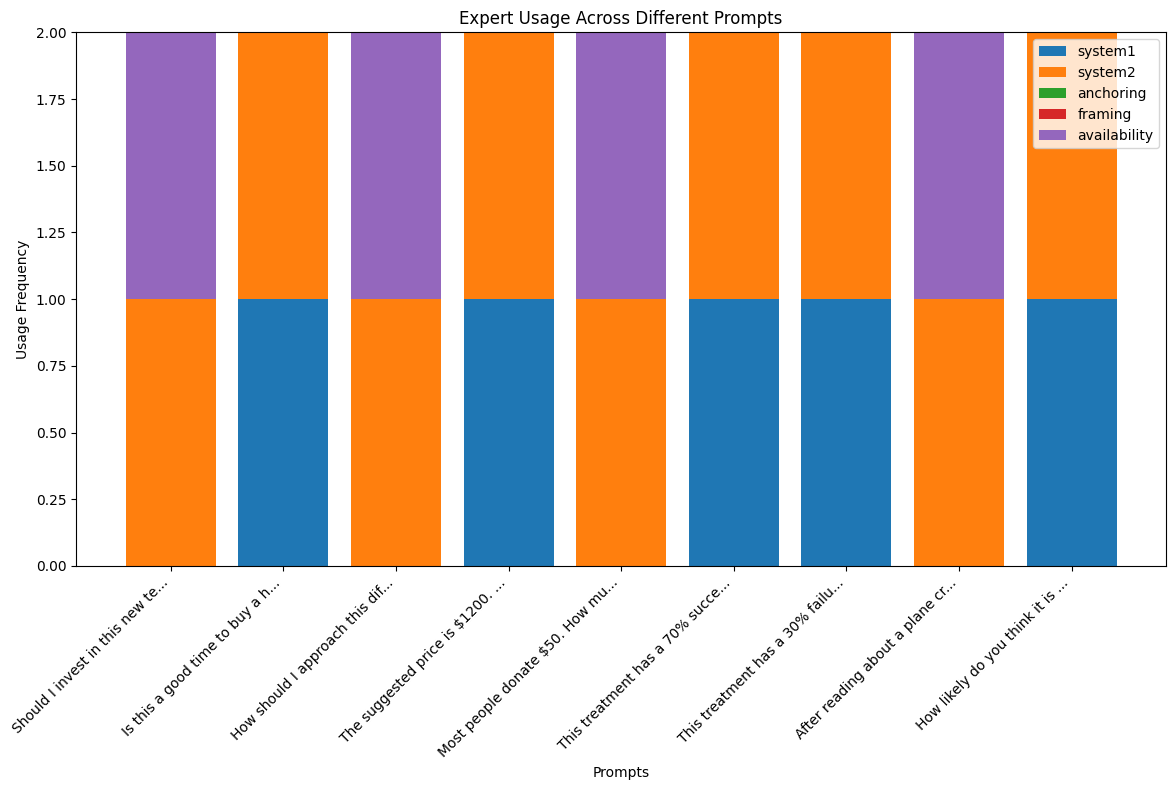

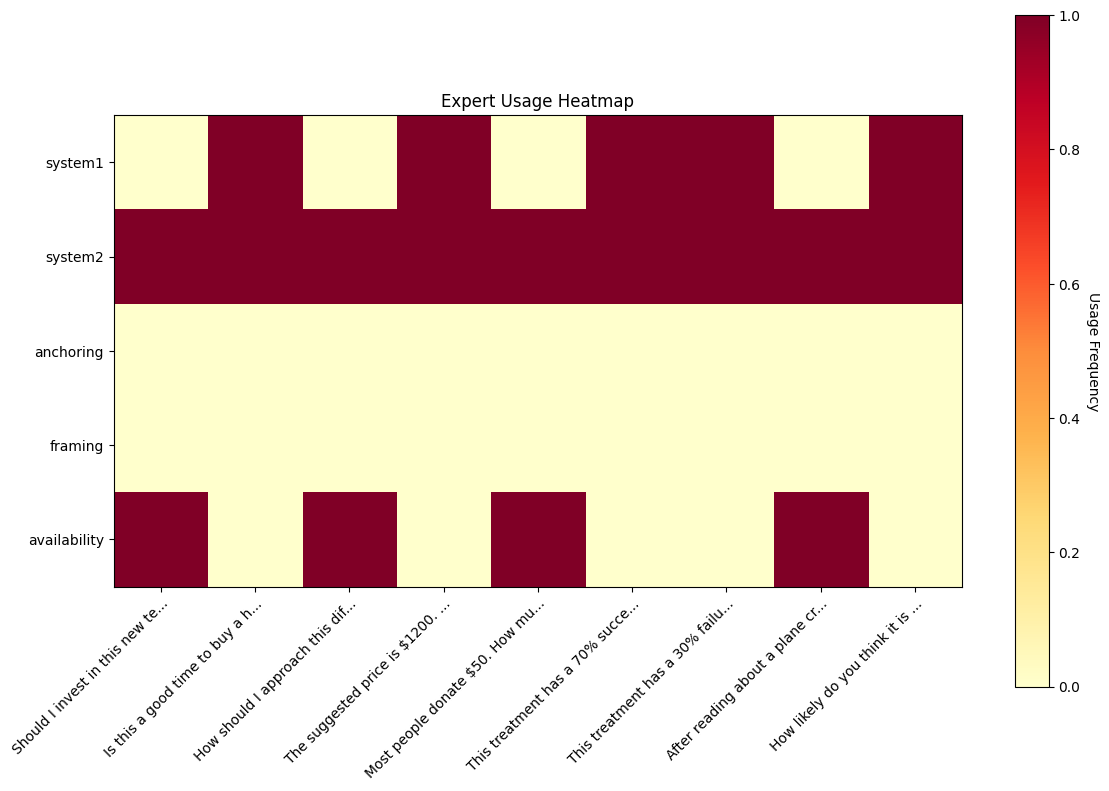

In [17]:
# Visualize expert usage
visualize_expert_usage(test_results, trained_moe_model.expert_names)

## 7. Comparison with Base Model

Let's compare the outputs of our MoE model with the base model to see how the expert specialization affects the responses.

In [18]:
def compare_with_base_model(base_model, tokenizer, moe_model, test_prompts):
    """
    Compare outputs from the base model and MoE model.
    """
    base_model.eval()
    moe_model.eval()
    
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        
        # Tokenize
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        
        # Generate with base model
        with torch.no_grad():
            base_outputs = base_model.generate(
                input_ids,
                max_length=input_ids.shape[1] + 50,
                temperature=0.7,
                top_p=0.9
            )
        
        base_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
        
        # Generate with MoE model
        with torch.no_grad():
            moe_outputs = moe_model.generate(
                input_ids=input_ids,
                attention_mask=torch.ones_like(input_ids),
                max_length=50,
                temperature=0.7,
                top_p=0.9
            )
        
        moe_text = tokenizer.decode(moe_outputs["generated_ids"][0], skip_special_tokens=True)
        
        # Get expert usage
        expert_usage = moe_outputs["expert_usage"]
        analysis = moe_model.get_expert_usage_analysis(expert_usage)
        
        # Find dominant expert
        dominant_expert = max(analysis["usage_frequency"].items(), key=lambda x: x[1])[0]
        
        print(f"\nBase Model Output:\n{base_text}")
        print(f"\nMoE Model Output (dominant expert: {dominant_expert}):\n{moe_text}")
        print("-" * 80)

In [19]:
# Compare with base model
# Select a subset of test prompts for comparison
comparison_prompts = test_prompts[:3]
compare_with_base_model(base_model, tokenizer, trained_moe_model, comparison_prompts)

/home/tsultanov/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tsultanov/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence,


Prompt: Should I invest in this new technology company?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Base Model Output:
Should I invest in this new technology company?

MoE Model Output (dominant expert: system2):
Should I invest in this new technology company?
--------------------------------------------------------------------------------

Prompt: Is this a good time to buy a house?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Base Model Output:
Is this a good time to buy a house?

MoE Model Output (dominant expert: system1):
Is this a good time to buy a house?
--------------------------------------------------------------------------------

Prompt: How should I approach this difficult conversation?

Base Model Output:
How should I approach this difficult conversation?

MoE Model Output (dominant expert: system2):
How should I approach this difficult conversation?
--------------------------------------------------------------------------------


## 8. Forcing Specific Experts

Let's implement a way to force the model to use specific experts, allowing us to explicitly control the thinking style.

In [20]:
def generate_with_forced_expert(model, tokenizer, prompt, expert_name, weight=0.9):
    """
    Generate text with a forced expert to control thinking style.
    """
    if expert_name not in model.expert_names:
        raise ValueError(f"Unknown expert: {expert_name}. Available experts: {model.expert_names}")
    
    expert_idx = model.expert_names.index(expert_name)
    
    # Create a custom router class that overrides the forward method
    original_forward = model.router.forward
    
    def forced_router_forward(hidden_states):
        batch_size = hidden_states.shape[0]
        top_k = model.top_k
        
        # Create indices tensor with the forced expert as the first choice
        indices = torch.zeros((batch_size, top_k), dtype=torch.long, device=hidden_states.device)
        indices[:, 0] = expert_idx
        
        # For the remaining slots, use other experts
        other_experts = [i for i in range(len(model.expert_names)) if i != expert_idx]
        for k in range(1, top_k):
            if k-1 < len(other_experts):
                indices[:, k] = other_experts[k-1]
            else:
                indices[:, k] = 0  # Default to first expert if we run out
        
        # Create weights tensor with high weight for the forced expert
        weights = torch.zeros((batch_size, top_k), dtype=torch.float, device=hidden_states.device)
        weights[:, 0] = weight  # High weight for forced expert
        remaining_weight = 1.0 - weight
        for k in range(1, top_k):
            weights[:, k] = remaining_weight / (top_k - 1)
        
        # Run original forward to get all routing probs for analysis
        _, _, all_routing_probs = original_forward(hidden_states)
        
        return indices, weights, all_routing_probs
    
    # Replace router forward method temporarily
    model.router.forward = forced_router_forward
    
    # Generate text
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=50,
            temperature=0.7,
            top_p=0.9
        )
    
    # Restore original router forward method
    model.router.forward = original_forward
    
    # Decode generated text
    generated_ids = outputs["generated_ids"]
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return generated_text, outputs["expert_usage"]

In [21]:
def test_forced_experts(model, tokenizer, prompt):
    """
    Test generating with different forced experts for the same prompt.
    """
    print(f"Prompt: {prompt}\n")
    
    for expert_name in model.expert_names:
        print(f"\nForced Expert: {expert_name}")
        generated_text, expert_usage = generate_with_forced_expert(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            expert_name=expert_name,
            weight=0.9
        )
        
        print(f"Generated: {generated_text}")
        
        # Analyze expert usage
        analysis = model.get_expert_usage_analysis(expert_usage)
        print("\nExpert Usage:")
        for name in model.expert_names:
            freq = analysis["usage_frequency"][name]
            weight = analysis["average_weight"][name]
            print(f"  {name}: {freq:.2f} frequency, {weight:.2f} average weight")
        
        print("-" * 40)

In [22]:
# Test with forced experts
test_prompt = "Should I make this important decision now or wait until tomorrow?"
test_forced_experts(trained_moe_model, tokenizer, test_prompt)

Prompt: Should I make this important decision now or wait until tomorrow?


Forced Expert: system1
Generated: Should I make this important decision now or wait until tomorrow?

Expert Usage:
  system1: 1.00 frequency, 0.90 average weight
  system2: 1.00 frequency, 0.10 average weight
  anchoring: 0.00 frequency, 0.00 average weight
  framing: 0.00 frequency, 0.00 average weight
  availability: 0.00 frequency, 0.00 average weight
----------------------------------------

Forced Expert: system2
Generated: Should I make this important decision now or wait until tomorrow?

Expert Usage:
  system1: 1.00 frequency, 0.10 average weight
  system2: 1.00 frequency, 0.90 average weight
  anchoring: 0.00 frequency, 0.00 average weight
  framing: 0.00 frequency, 0.00 average weight
  availability: 0.00 frequency, 0.00 average weight
----------------------------------------

Forced Expert: anchoring
Generated: Should I make this important decision now or wait until tomorrow?

Expert Usage:
  system1

## 9. Saving and Loading the Model

Let's implement functions to save and load our MoE model for future use.

In [23]:
def save_moe_model(model, tokenizer, save_dir):
    """
    Save the MoE model and tokenizer.
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save base model and tokenizer
    model.base_model.save_pretrained(os.path.join(save_dir, "base_model"))
    tokenizer.save_pretrained(os.path.join(save_dir, "tokenizer"))
    
    # Save expert adapters and router
    torch.save(model.experts.state_dict(), os.path.join(save_dir, "experts.pt"))
    torch.save(model.router.state_dict(), os.path.join(save_dir, "router.pt"))
    torch.save(model.output_projection.state_dict(), os.path.join(save_dir, "output_projection.pt"))
    
    # Save configuration
    config = {
        "num_experts": model.num_experts,
        "top_k": model.top_k,
        "hidden_size": model.hidden_size,
        "expert_names": model.expert_names,
        "bottleneck_size": model.experts[0].down_project.out_features
    }
    
    with open(os.path.join(save_dir, "config.json"), "w") as f:
        json.dump(config, f)
    
    print(f"Model saved to {save_dir}")

def load_moe_model(save_dir):
    """
    Load the MoE model and tokenizer.
    """
    # Load configuration
    with open(os.path.join(save_dir, "config.json"), "r") as f:
        config = json.load(f)
    
    # Load base model and tokenizer
    base_model = AutoModelForCausalLM.from_pretrained(os.path.join(save_dir, "base_model"))
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(save_dir, "tokenizer"))
    
    # Initialize MoE model
    model = ThinkingFastSlowMoE(
        base_model=base_model,
        tokenizer=tokenizer,
        num_experts=config["num_experts"],
        bottleneck_size=config["bottleneck_size"],
        top_k=config["top_k"]
    )
    
    # Override expert names
    model.expert_names = config["expert_names"]
    
    # Load expert adapters and router
    model.experts.load_state_dict(torch.load(os.path.join(save_dir, "experts.pt")))
    model.router.load_state_dict(torch.load(os.path.join(save_dir, "router.pt")))
    model.output_projection.load_state_dict(torch.load(os.path.join(save_dir, "output_projection.pt")))
    
    print(f"Model loaded from {save_dir}")
    return model, tokenizer

In [24]:
# Save the model
save_dir = "thinking_fast_slow_moe_model"
save_moe_model(trained_moe_model, tokenizer, save_dir)

Model saved to thinking_fast_slow_moe_model


In [25]:
# Load the model (commented out to avoid reloading unnecessarily)
# loaded_model, loaded_tokenizer = load_moe_model(save_dir)
# test_forced_experts(loaded_model, loaded_tokenizer, test_prompt)

## 10. Conclusion and Comparison with CAV Approach

Let's compare the Mixture of Experts approach with the previous Concept Activation Vectors approach.

### Comparison of MoE vs. CAV Approaches

| Aspect | Mixture of Experts (MoE) | Concept Activation Vectors (CAV) |
|--------|--------------------------|----------------------------------|
| **Core Mechanism** | Uses separate expert modules for different thinking styles | Identifies and manipulates directions in activation space |
| **Architecture** | Modifies model architecture with expert-specific adapters | Keeps model architecture unchanged, manipulates activations |
| **Training** | Requires training the expert adapters and router | Only trains linear classifiers to identify concept directions |
| **Interpretability** | Explicit separation of thinking styles into different modules | Implicit representation of thinking styles as directions |
| **Control** | Can force specific experts to control thinking style | Can control steering strength to enhance/suppress concepts |
| **Computational Cost** | Higher (multiple expert modules) | Lower (only adds concept vectors during inference) |
| **Theoretical Alignment** | Directly models dual-process theory with separate pathways | Represents concepts as continuous directions in semantic space |

### Advantages of MoE for "Thinking Fast and Slow"

1. **Explicit Dual-Process Modeling**: MoE directly implements Kahneman's dual-process theory by having separate expert modules for System 1 and System 2 thinking.

2. **Dynamic Expert Selection**: The router network dynamically decides which thinking style to use based on the input, similar to how humans switch between intuitive and analytical thinking.

3. **Competitive Processing**: MoE can model the competition between System 1 and System 2 processes, with the router determining which expert gets more weight.

4. **Interpretable Expert Usage**: We can analyze which experts are activated for different inputs, providing insights into when different thinking styles are used.

5. **Modular Architecture**: Easy to add new experts for additional cognitive biases or thinking styles.

### Limitations and Future Work

1. **Training Data Requirements**: MoE requires more training data and computation than CAV.

2. **Architectural Complexity**: More complex architecture with multiple expert modules.

3. **Future Extensions**:
   - Implement more sophisticated routing mechanisms
   - Add experts for additional cognitive biases
   - Combine MoE with CAV for even more control
   - Evaluate on more complex decision-making tasks

This Mixture of Experts implementation provides a novel and theoretically grounded approach to modeling Kahneman's theories in language models, making it an excellent choice for a master's thesis on assessing deep learning architectures for learning expertise.